In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

In [3]:
from lib.geo import __c
from lib.sim_data_i3 import I3SimHandlerFtr
from lib.network import TriplePandleNet
from lib.plotting_tools import plot_event, adjust_plot_1d
from time_sampler import sample_times

2024-05-21 18:08:05.194756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
key = jax.random.PRNGKey(2)

In [5]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [6]:
# Get a simulated muon event.

event_index = 5
meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 3.4 TeV
n_doms 43


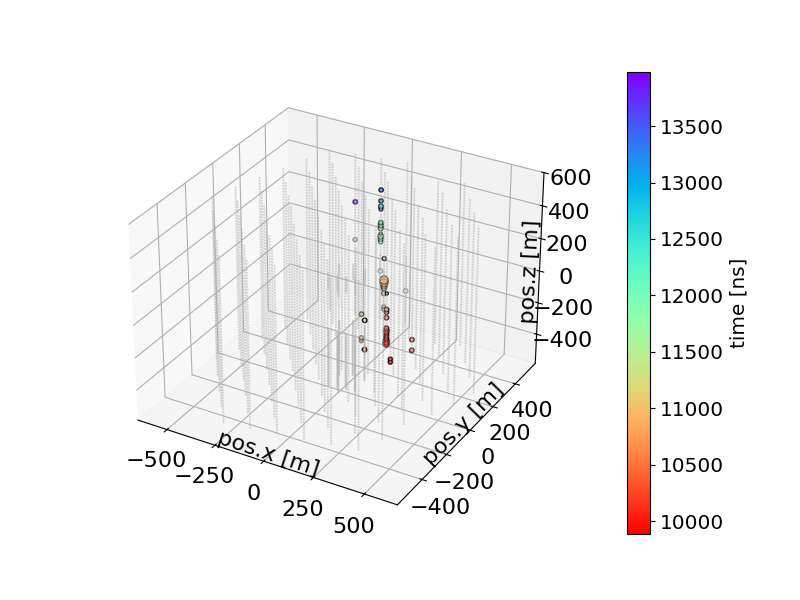

In [7]:
plot_event(event_data, geo=sim_handler.geo)

In [7]:
# Let's generate some new first hit times following our triple pandel model.
# (avoid problems with time smearing for now -> to be implemented: gaussian convoluted triple pandel.)

track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = jnp.float64(meta['muon_time'])
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

network = TriplePandleNet('./data/network/')

In [8]:
# Compute position of muon at the time of the highest charge dom hit.
# or use charge weighted mean of first hit

print("old track vertex:", track_pos)

from lib.geo import get_xyz_from_zenith_azimuth
#idx = np.argmax(event_data['charge'])
#centered_track_time = event_data.iloc[idx]['time']
centered_track_time = np.sum(event_data['charge'] * event_data['time']) / np.sum(event_data['charge'])
centered_track_pos = track_pos + (centered_track_time - track_time) * __c * get_xyz_from_zenith_azimuth(track_src)
print("new track vertex:", centered_track_pos)

centered_track_time = jnp.float64(centered_track_time)
centered_track_pos = jnp.array(centered_track_pos)

old track vertex: [ 143.40123598  106.94081331 -815.20509865]
new track vertex: [ -25.42355091  403.14288541 -154.63778486]


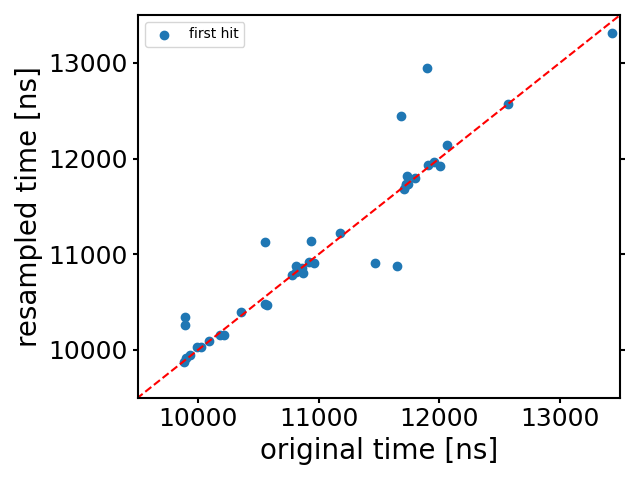

In [10]:
key, subkey = jax.random.split(key)
first_times = sample_times(event_data, track_pos, track_src, track_time, network, subkey)

# compare to original first hit times
fig, ax = plt.subplots()
ax.scatter(event_data['time'], first_times, label='first hit')
plt.plot([0, 100000], [0, 100000], "r--")

plot_args = {'xlim':[9500, 13500],
                 'ylim':[9500, 13500],
                 'xlabel':'original time [ns]',
                 'ylabel':'resampled time [ns]'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [11]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fake_event_data = jnp.column_stack([jnp.array(event_data[['x', 'y', 'z']].to_numpy()), 
                                    jnp.array(first_times), 
                                    jnp.array(n_photons)])
print(fake_event_data.shape)

# Send to GPU.
fake_event_data.devices()
centered_track_pos.devices()
centered_track_time.devices()
track_src.devices()

(43, 5)


{cuda(id=0)}

In [12]:
from lib.geo import cherenkov_cylinder_coordinates_v
from lib.geo import rho_dom_relative_to_track_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs_v, transform_network_inputs_v
from typing import Any
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

@jax.jit
def neg_mpe_llh_direction_const_vertex(track_direction,
                                       track_vertex, 
                                       track_time,
                                       event_data,
                                       eps):
    """
    track_direction: (zenith, azimuth) in radians
    track_vertex: (x, y, z)
    track_time: t (this time defines the fit vertex)
    event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
    """
    print(track_direction)
    
    dom_positions = event_data[:, :3]
    first_hit_times = event_data[:, 3]
    n_photons = event_data[:, 4]

    track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
    
    geo_time, closest_approach_dist, closest_approach_z = \
    cherenkov_cylinder_coordinates_v(dom_positions,
                                     track_vertex,
                                     track_dir_xyz)

    closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, 
                                                       track_vertex, 
                                                       track_dir_xyz)

    track_zenith = track_direction[0]
    track_azimuth = track_direction[1]
    x = jnp.column_stack([closest_approach_dist,
                      closest_approach_rho,
                      closest_approach_z,
                      jnp.repeat(track_zenith, len(closest_approach_dist)),
                      jnp.repeat(track_azimuth, len(closest_approach_dist))])

    x_prime = transform_network_inputs_v(x)
    y_pred = network.eval_on_batch(x_prime)
    logits, av, bv = transform_network_outputs_v(y_pred)

    gm = tfd.MixtureSameFamily(
              mixture_distribution=tfd.Categorical(
                  logits=logits
                  ),
              components_distribution=tfd.Gamma(
                concentration=av,
                rate=bv,
                force_probs_to_zero_outside_support=True
                  )
            )

    delay_time = first_hit_times - (geo_time + track_time)
    llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
    llh = llh + eps
    return -2*jnp.sum(llh)

In [13]:
eps = jnp.float64(1.e-15)
llh = neg_mpe_llh_direction_const_vertex(track_src, 
                                         centered_track_pos, 
                                         centered_track_time, 
                                         fake_event_data, 
                                         eps)
print(llh)

Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=1/0)>
-6.277457311320885


In [14]:
neg_mpe_llh_direction_const_vertex_v = jax.jit(jax.vmap(neg_mpe_llh_direction_const_vertex, (0, None, None, None, None), 0))

[2.66512738 5.23043102]


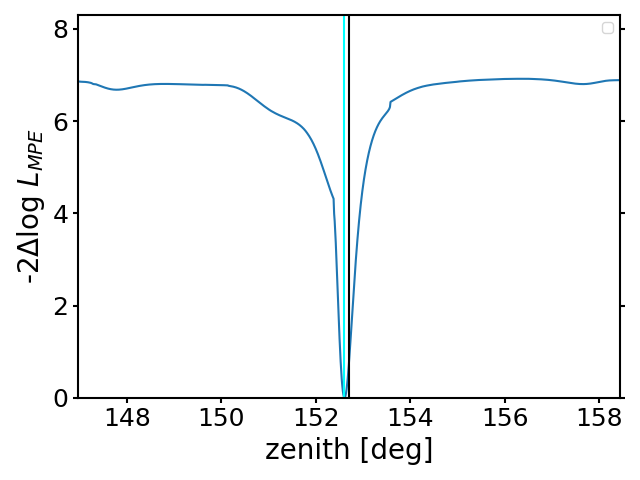

In [68]:
print(track_src)
n_eval = 1000
zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.repeat(track_src[1], n_eval)
init_dirs = np.column_stack([zenith, azimuth])
init_dirs = jnp.array(init_dirs)
logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, 
                                     centered_track_pos, 
                                     centered_track_time, 
                                     fake_event_data, 
                                     eps)
delta_logl = logls-np.amin(logls)

fig, ax = plt.subplots()
plt.plot(np.rad2deg(zenith), logls-np.amin(logls))
ax.axvline(np.rad2deg(track_src[0]), color='k')
#ax.axvline(np.rad2deg(meta['spline_mpe_zenith']), color='r')
ax.axvline(np.rad2deg([2.66320856]), color='cyan')


plot_args = {'xlim':[np.rad2deg(zenith[0]), np.rad2deg(zenith[-1])],
             'ylim':[0.0, 1.2*np.amax(delta_logl)],
             'xlabel':'zenith [deg]',
             'ylabel':'-2$\\Delta$log $L_{MPE}$'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

[2.66512738 5.23043102]


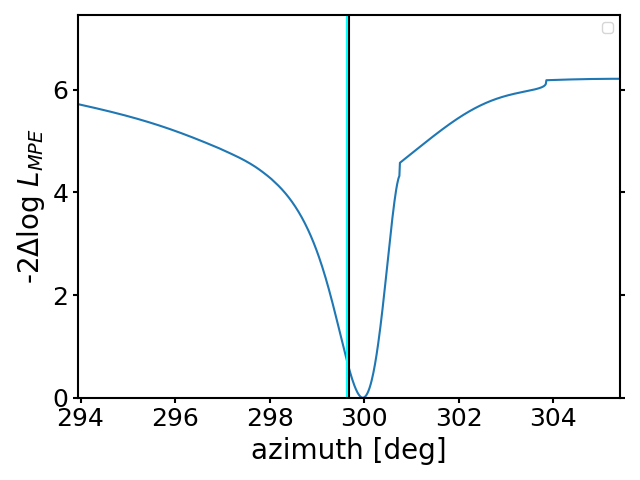

In [70]:
print(track_src)
n_eval = 1000
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
zenith = np.repeat(track_src[0], n_eval)
init_dirs = np.column_stack([zenith, azimuth])
init_dirs = jnp.array(init_dirs)

logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, 
                                     centered_track_pos, 
                                     centered_track_time, 
                                     fake_event_data, 
                                     eps)

delta_logl = logls-np.amin(logls)

fig, ax = plt.subplots()
plt.plot(np.rad2deg(azimuth), delta_logl)
ax.axvline(np.rad2deg(track_src[1]), color='k')
#ax.axvline(np.rad2deg(meta['spline_mpe_azimuth']), color='r')
ax.axvline(np.rad2deg([5.22943805]), color='cyan')

plot_args = {'xlim':[np.rad2deg(azimuth[0]), np.rad2deg(azimuth[-1])],
             'ylim':[0.0, 1.2*np.amax(delta_logl)],
             'xlabel':'azimuth [deg]',
             'ylabel':'-2$\\Delta$log $L_{MPE}$'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

(200, 200)


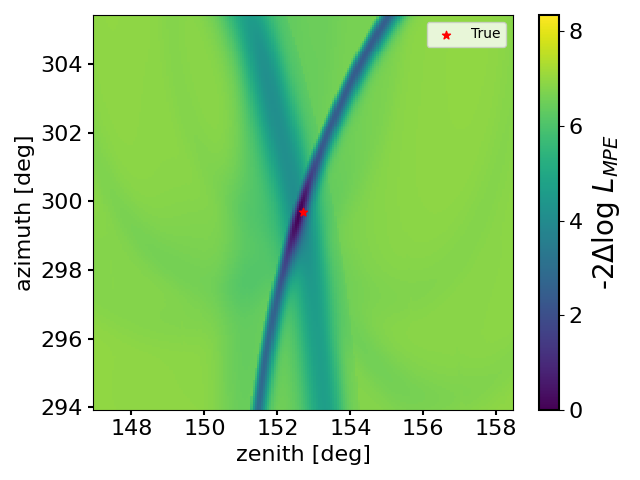

In [36]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
X, Y = np.meshgrid(zenith, azimuth)
print(X.shape)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_mpe_llh_direction_const_vertex_v(init_dirs, 
                                     centered_track_pos, 
                                     centered_track_time, 
                                     fake_event_data, 
                                     eps)
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")
#ax.scatter(np.rad2deg(meta['spline_mpe_zenith']), np.rad2deg(meta['spline_mpe_azimuth']), marker="x", color='cyan', label="SplineMPE")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
%timeit neg_mpe_llh_direction_const_vertex_v(init_dirs, centered_track_pos, centered_track_time, fake_event_data, eps)

1.54 s ± 7.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
#import jaxopt
#init_dir = jnp.array([meta['spline_mpe_zenith'], meta['spline_mpe_azimuth']])
#print(init_dir)
#print(neg_mpe_llh_direction_const_vertex(init_dir, 
#                                         centered_track_pos, 
#                                         centered_track_time, 
#                                         fake_event_data, eps))

In [20]:
#solver_1 = jaxopt.ScipyMinimize(method = "l-bfgs-b", fun=neg_mpe_llh_direction_const_vertex, tol = 1e-12, maxiter=5000)
#solver_1_sol = solver_1.run(init_dir, centered_track_pos, centered_track_time, fake_event_data, eps)
#print(solver_1_sol.params)

In [21]:
#print(solver_1_sol)

In [22]:
'''
solver_2 = jaxopt.LBFGS(fun=neg_mpe_llh_direction_const_vertex, 
                        maxiter=5000, 
                        max_stepsize=1.e-4)

solver_2_sol = solver_2.run(init_dir, 
                            centered_track_pos, 
                            centered_track_time, 
                            fake_event_data,
                            eps)

print(solver_2_sol.params)
'''

'\nsolver_2 = jaxopt.LBFGS(fun=neg_mpe_llh_direction_const_vertex, \n                        maxiter=5000, \n                        max_stepsize=1.e-4)\n\nsolver_2_sol = solver_2.run(init_dir, \n                            centered_track_pos, \n                            centered_track_time, \n                            fake_event_data,\n                            eps)\n\nprint(solver_2_sol.params)\n'

In [17]:
from functools import partial

def get_neg_llh(network, event_data, eps=jnp.float64(1.e-20)):

    @jax.jit
    def neg_mpe_llh_direction_const_vertex2(track_direction,
                                           track_vertex, 
                                           track_time):
        """
        track_direction: (zenith, azimuth) in radians
        track_vertex: (x, y, z)
        track_time: t (this time defines the fit vertex)
        event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
        """
        print(track_direction)
        
        dom_positions = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        n_photons = event_data[:, 4]
    
        track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
        
        geo_time, closest_approach_dist, closest_approach_z = \
        cherenkov_cylinder_coordinates_v(dom_positions,
                                         track_vertex,
                                         track_dir_xyz)
    
        closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, 
                                                           track_vertex, 
                                                           track_dir_xyz)
    
        track_zenith = track_direction[0]
        track_azimuth = track_direction[1]
        x = jnp.column_stack([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          jnp.repeat(track_zenith, len(closest_approach_dist)),
                          jnp.repeat(track_azimuth, len(closest_approach_dist))])
    
        x_prime = transform_network_inputs_v(x)
        y_pred = network.eval_on_batch(x_prime)
        logits, av, bv = transform_network_outputs_v(y_pred)
    
        gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=av,
                    rate=bv,
                    force_probs_to_zero_outside_support=True
                      )
                )
    
        delay_time = first_hit_times - (geo_time + track_time)
        llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
        llh = llh + eps
        return -2*jnp.sum(llh)

    return neg_mpe_llh_direction_const_vertex2

In [18]:
neg_llh = get_neg_llh(network, fake_event_data)

In [19]:
neg_llh_v = jax.jit(jax.vmap(neg_llh, (0, None, None), 0))

In [20]:
f = jax.value_and_grad(neg_llh)

In [48]:
neg_llh(track_src, centered_track_pos, centered_track_time)

Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=1/0)>


Array(-6.27745731, dtype=float64)

In [50]:
f(track_src, centered_track_pos, centered_track_time)

(Array(-6.27745731, dtype=float64),
 Array([ 804.97681767, -188.2845212 ], dtype=float64))

(200, 200)


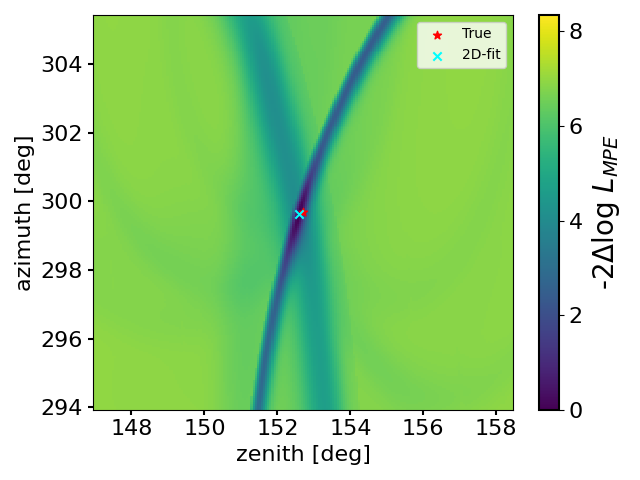

In [65]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
X, Y = np.meshgrid(zenith, azimuth)
print(X.shape)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh_v(init_dirs, centered_track_pos, centered_track_time) 

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")
#ax.scatter(np.rad2deg(meta['spline_mpe_zenith']), np.rad2deg(meta['spline_mpe_azimuth']), marker="x", color='cyan', label="SplineMPE")
ax.scatter(np.rad2deg([2.66320856]), np.rad2deg([5.22943805]), marker="x", color='cyan', label='2D-fit')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
%timeit logls = neg_llh_v(init_dirs, centered_track_pos, centered_track_time) 

1.53 s ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
from functools import partial

def get_neg_llh(network, event_data, track_vertex, track_time, eps=jnp.float64(1.e-20), ):

    @jax.jit
    def neg_mpe_llh_direction_const_vertex2(track_direction):
        """
        track_direction: (zenith, azimuth) in radians
        track_vertex: (x, y, z)
        track_time: t (this time defines the fit vertex)
        event_data: 2D array (n_doms X 5) where columns are x,y,z of dom location, and t for first hit time, and estimated number of photon hits from Qtot.
        """
        print(track_direction)
        
        dom_positions = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        n_photons = event_data[:, 4]
    
        track_dir_xyz = get_xyz_from_zenith_azimuth(track_direction)
        
        geo_time, closest_approach_dist, closest_approach_z = \
        cherenkov_cylinder_coordinates_v(dom_positions,
                                         track_vertex,
                                         track_dir_xyz)
    
        closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, 
                                                           track_vertex, 
                                                           track_dir_xyz)
    
        track_zenith = track_direction[0]
        track_azimuth = track_direction[1]
        x = jnp.column_stack([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          jnp.repeat(track_zenith, len(closest_approach_dist)),
                          jnp.repeat(track_azimuth, len(closest_approach_dist))])
    
        x_prime = transform_network_inputs_v(x)
        y_pred = network.eval_on_batch(x_prime)
        logits, av, bv = transform_network_outputs_v(y_pred)
    
        gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=av,
                    rate=bv,
                    force_probs_to_zero_outside_support=True
                      )
                )
    
        delay_time = first_hit_times - (geo_time + track_time)
        llh = n_photons * gm.prob(delay_time) * (1-gm.cdf(delay_time))**(n_photons-1)
        llh = llh + eps
        return -2*jnp.sum(llh)

    return neg_mpe_llh_direction_const_vertex2

In [28]:
neg_llh = get_neg_llh(network, fake_event_data, centered_track_pos, centered_track_time)

In [29]:
grad = jax.grad(neg_llh, argnums=0)

In [30]:
def newton(f, x_0, tol=1e-5, max_iter=15):
    """
    A multivariate Newton root-finding routine.

    """
    x = x_0
    f_jac = jax.jacobian(f)
    @jax.jit
    def q(x):
        " Updates the current guess. "
        return x - jnp.linalg.solve(f_jac(x), f(x))
    error = tol + 1
    n = 0
    while error > tol:
        n += 1
        if(n > max_iter):
            raise Exception('Max iteration reached without convergence')
        y = q(x)
        error = jnp.linalg.norm(x - y)
        x = y
        print(f'iteration {n}, error = {error}')
    return x

In [39]:
x0 = jnp.array(track_src)
for i in range(100):
    dx = grad(x0)
    print(dx)
    x0 -= 1.e-7 * grad(x0)

[ 804.97681767 -188.2845212 ]
[ 783.76813301 -183.71226397]
[ 761.14366724 -178.67213801]
[ 737.26140805 -173.20697685]
[ 712.28420059 -167.36586321]
[ 686.37785532 -161.20311261]
[ 659.71277389 -154.77683096]
[ 632.4674145  -148.14713681]
[ 604.83066358 -141.37424555]
[ 577.00065364 -134.51665279]
[ 549.17938882 -127.62961142]
[ 521.56445143 -120.76400202]
[ 494.34002374 -113.96560066]
[ 467.66932664 -107.27468926]
[ 441.68979953 -100.72593413]
[416.51139099 -94.34846461]
[392.21751605 -88.16609892]
[368.86777178 -82.19767673]
[346.50144511 -76.45746547]
[325.14107408 -70.95561111]
[304.79564389 -65.69860817]
[285.46326608 -60.68976766]
[267.13335184 -55.92966762]
[249.78836135 -51.41657577]
[233.40522334 -47.14683805]
[217.95650621 -43.11523022]
[203.41140118 -39.31527172]
[189.73655854 -35.73950268]
[176.89680494 -32.37972571]
[164.8557596  -29.22721489]
[153.57636217 -26.27289449]
[143.02132183 -23.5074903 ]
[133.15349544 -20.92165619]
[123.93620192 -18.50607884]
[115.33347932 -16.

In [41]:
import jaxopt

In [55]:
solver_2 = jaxopt.LBFGS(fun=neg_llh, 
                        maxiter=1000, 
                        max_stepsize=1.e-3)

solver_2_sol = solver_2.run(jnp.array(track_src))

print(solver_2_sol.params)

[2.66307258 5.23008076]


In [56]:
solver_2_sol.state

LbfgsState(iter_num=Array(1000, dtype=int64, weak_type=True), value=Array(-7.02774985, dtype=float64), grad=Array([-220.84013572,   64.03885008], dtype=float64), stepsize=Array(0.001, dtype=float64), error=Array(229.93768691, dtype=float64), s_history=Array([[ 1.36864317e-07, -6.05670402e-07],
       [ 1.36726850e-07, -6.05136023e-07],
       [ 1.36589529e-07, -6.04602088e-07],
       [ 1.36452352e-07, -6.04068577e-07],
       [ 1.36315305e-07, -6.03535437e-07],
       [ 1.36178415e-07, -6.03002782e-07],
       [ 1.36041658e-07, -6.02470509e-07],
       [ 1.35905050e-07, -6.01938688e-07],
       [ 1.35768578e-07, -6.01407262e-07],
       [ 1.35632257e-07, -6.00876298e-07]], dtype=float64), y_history=Array([[ 0.2230587 , -0.06467577],
       [ 0.22283563, -0.0646111 ],
       [ 0.22261279, -0.0645465 ],
       [ 0.22239019, -0.06448197],
       [ 0.22216778, -0.0644175 ],
       [ 0.22194562, -0.0643531 ],
       [ 0.22172366, -0.06428875],
       [ 0.22150194, -0.06422448],
       [ 0.

In [47]:
print(track_src)

[2.66512738 5.23043102]


In [49]:
%timeit solver_2.run(jnp.array(track_src))

KeyboardInterrupt: 

In [58]:
%timeit solver_2.run(jnp.array(track_src)) # 8 seconds

7.95 s ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
solver_1 = jaxopt.ScipyMinimize(method = "bfgs", fun=neg_llh, tol = 1e-5, maxiter=1000, 
                                options = {'xrtol':1.e-5})

solver_1_sol = solver_1.run(jnp.array(track_src))
print(solver_1_sol.params)

[2.66320856 5.22943805]


In [61]:
solver_1_sol.state

ScipyMinimizeInfo(fun_val=Array(-7.06280961, dtype=float64, weak_type=True), success=True, status=0, iter_num=6, hess_inv=Array([[8.15727259e-06, 2.62636750e-05],
       [2.62636750e-05, 1.02885665e-04]], dtype=float64), num_fun_eval=Array(19, dtype=int32), num_jac_eval=Array(9, dtype=int32), num_hess_eval=Array(0, dtype=int32))

In [62]:
%timeit solver_1.run(jnp.array(track_src))

74.4 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
